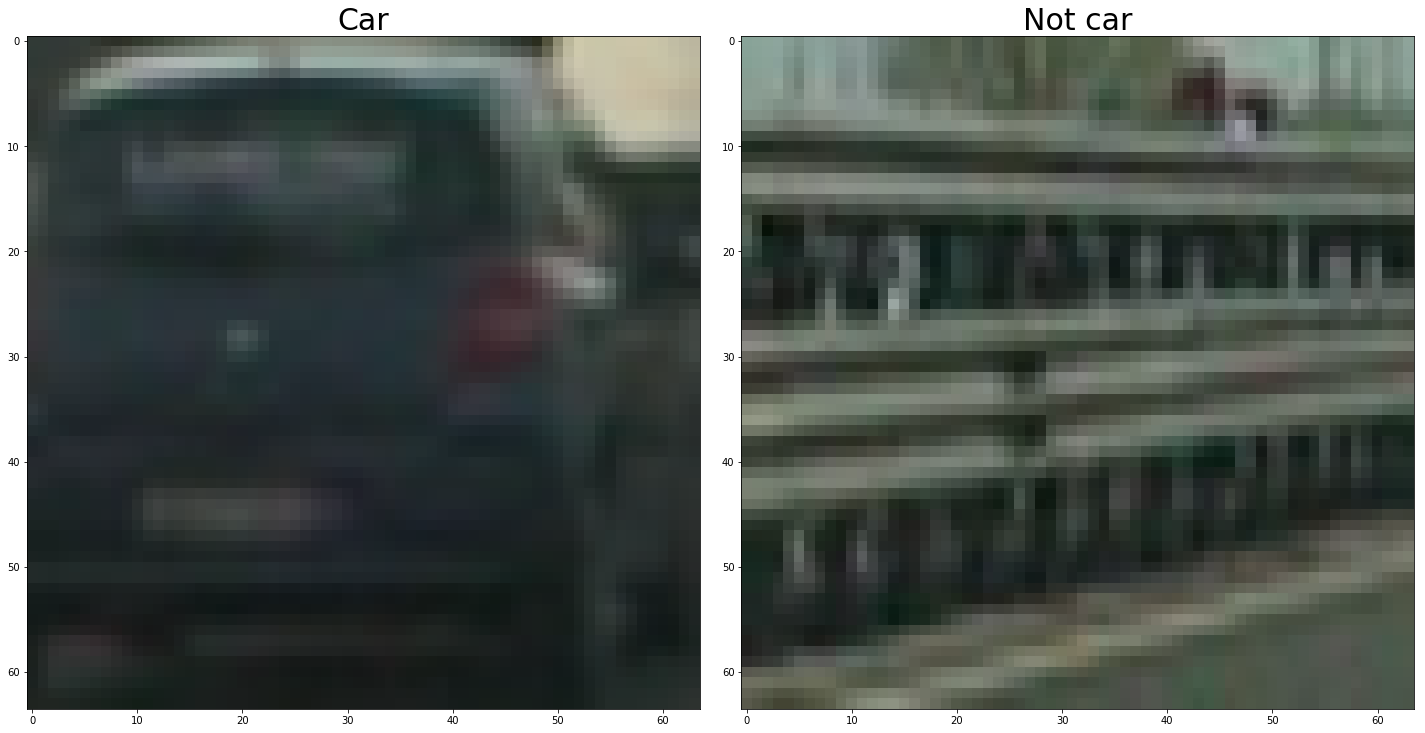

In [29]:
#1

import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline

vehicles = glob.glob('vehicles/*/*.png')
non_vehicles = glob.glob('non-vehicles/*/*.png')

vehicle = mpimg.imread(vehicles[np.random.randint(0, len(vehicles))])
non_vehicle = mpimg.imread(non_vehicles[np.random.randint(0, len(non_vehicles))])
# print(vehicle[:3,:3,0])
# print(non_vehicle[:3,:3,0])

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.tight_layout()
ax1.imshow(vehicle)
ax1.set_title('Car', fontsize=30)
ax2.imshow(non_vehicle)
ax2.set_title('Not car', fontsize=30)

# plt.savefig('output_images/car_not_car.jpg')

In [33]:
#2

from skimage.feature import hog


orient = 9
pix_per_cell = 8
cell_per_block = 2


def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)


def get_hog_features(img, orient, pix_per_cell, cell_per_block,
                        vis=False, feature_vec=True, block_norm='L1'):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient,
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  transform_sqrt=False, block_norm=block_norm
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:
        features = hog(img, orientations=orient,
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block),
                       transform_sqrt=False, block_norm=block_norm
                       visualise=vis, feature_vector=feature_vec)
        return features


def extract_features(img):
    converted = convert_color(img, conv='RGB2YCrCb')
    ch1 = converted[:,:,0]
    ch2 = converted[:,:,1]
    ch3 = converted[:,:,2]
    hog1, hog1_image = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, vis=True, feature_vec=False)
    return hog1_image, ch1, ch2, ch3


vehicle = mpimg.imread(vehicles[np.random.randint(0, len(vehicles))])
non_vehicle = mpimg.imread(non_vehicles[np.random.randint(0, len(non_vehicles))])

v_hog, v_ch1, v_ch2, v_ch3 = extract_features(vehicle)
nv_hog, nv_ch1, nv_ch2, nv_ch3 = extract_features(non_vehicle)

fig_sets = [
    ('Car CH-1', v_ch1), ('Car CH-1 HOG', v_hog), ('not-Car CH-1', nv_ch1), ('not-Car CH-1 HOG', nv_hog),
    ('Car CH-1', v_ch1), ('Car CH-1 Features', v_ch1), ('not-Car CH-1', nv_ch1), ('not-Car CH-1 Features', nv_ch1),
    ('Car CH-2', v_ch2), ('Car CH-2 Features', v_ch2), ('not-Car CH-2', nv_ch2), ('not-Car CH-2 Features', nv_ch2),
    ('Car CH-3', v_ch3), ('Car CH-3 Features', v_ch3), ('not-Car CH-3', nv_ch3), ('not-Car CH-3 Features', nv_ch3),
]

n_rows = 4
n_cols = 4
fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols*6, n_rows*6))
fig.tight_layout()
for i in range(n_rows):
    for j in range(n_cols):
        idx = i*n_cols+j
        title, img = fig_sets[idx]
        axs[i][j].axis('off')
        axs[i][j].imshow(img, cmap='gray')
        axs[i][j].set_title(title, fontsize=40)

# plt.savefig('output_images/HOG_example.jpg')

SyntaxError: invalid syntax (<ipython-input-33-141c9d1ed9fa>, line 28)

In [ ]:
#3

import random
import time
import pickle
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split
from sklearn.model_selection import cross_val_score

# Define a function to compute binned color features
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel()
    # Return the feature vector
    return features

# Define a function to compute color histogram features
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, conv='RGB2YCrCb', spatial_size=(32, 32),
                     hist_bins=32, orient=9, pix_per_cell=4, cell_per_block=2,
                     block_norm='L1', hog_channel='ALL',
                     spatial_feat=True, hist_feat=False, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        feature_image = convert_color(image, conv=conv)

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel],
                                        orient, pix_per_cell, cell_per_block,
                                        vis=False, feature_vec=True, block_norm=block_norm))
                hog_features = np.ravel(hog_features)
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient,
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True, block_norm=block_norm)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features


sample_size = 1000
if sample_size > 0:
    cars = random.sample(vehicles, sample_size)
    notcars = random.sample(non_vehicles, sample_size)
else:
    cars = vehicles
    notcars = non_vehicles

rand_state = np.random.randint(0, 100)

def test_classifier(orient=9, pix_per_cell=4, cell_per_block=2, spatial_feat=True, hist_feat=False, hog_feat=True, block_norm='L1'):
#     print('orient:', orient, 'pix_per_cell:', pix_per_cell, 'cell_per_block:', cell_per_block)
    print('spatial_feat:', spatial_feat, 'hist_feat:', hist_feat, 'hog_feat:', hog_feat)
    
    car_features = extract_features(cars, orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
                                    spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)
    notcar_features = extract_features(notcars, orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
                                      spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)

    X = np.vstack((car_features, notcar_features)).astype(np.float64)
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)

    # Define the labels vector
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

    svc = LinearSVC()
    scores = cross_val_score(svc, scaled_X, y, cv=5)
    print('Test Accuracy of SVC = ', round(scores.mean(), 4))
    print('------------------------------------')

# for spatial_feat in [True, False]:
#     for hist_feat in [True, False]:
#         for hog_feat in [True, False]:
#             if spatial_feat is False and hist_feat is False and hog_feat is False: continue
#             test_classifier(spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)
            
# for orient in  [9]:
#     for pix_per_cell in [4, 8, 16]:
#         for cell_per_block in [1, 2, 3]:
#             test_classifier(orient, pix_per_cell, cell_per_block)

for block_norm in ['L1', 'L1-sqrt', 'L2', 'L2-Hys']:
    test_classifier(block_norm)

In [4]:
#4

import time
import pickle
from sklearn.svm import LinearSVC
from sklearn.cross_validation import train_test_split

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, conv='RGB2YCrCb', orient=9, pix_per_cell=8, cell_per_block=2):
    features = []
    for file in imgs:
        file_features = []
        image = mpimg.imread(file)
        feature_image = convert_color(image, conv=conv)
        hog_features = []
        for channel in range(feature_image.shape[2]):
            hog_features.append(get_hog_features(feature_image[:,:,channel],
                                orient, pix_per_cell, cell_per_block,
                                vis=False, feature_vec=True))
        hog_features = np.ravel(hog_features)
        features.append(hog_features)
    return features

sample_size = None
cars = vehicles[0:sample_size]
notcars = non_vehicles[0:sample_size]

car_features = extract_features(cars)
notcar_features = extract_features(notcars)

X = np.vstack((car_features, notcar_features)).astype(np.float64)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand_state)

# Use a linear SVC
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

dist_pickle = {}
dist_pickle["svc"] = svc
pickle.dump(dist_pickle, open("dist_pickle.p", "wb"))


/Users/kei/.anyenv/envs/pyenv/versions/anaconda3-2.5.0/envs/carnd-term1/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/kei/.anyenv/envs/pyenv/versions/anaconda3-2.5.0/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


6.19 Seconds to train SVC...
Test Accuracy of SVC =  0.9828


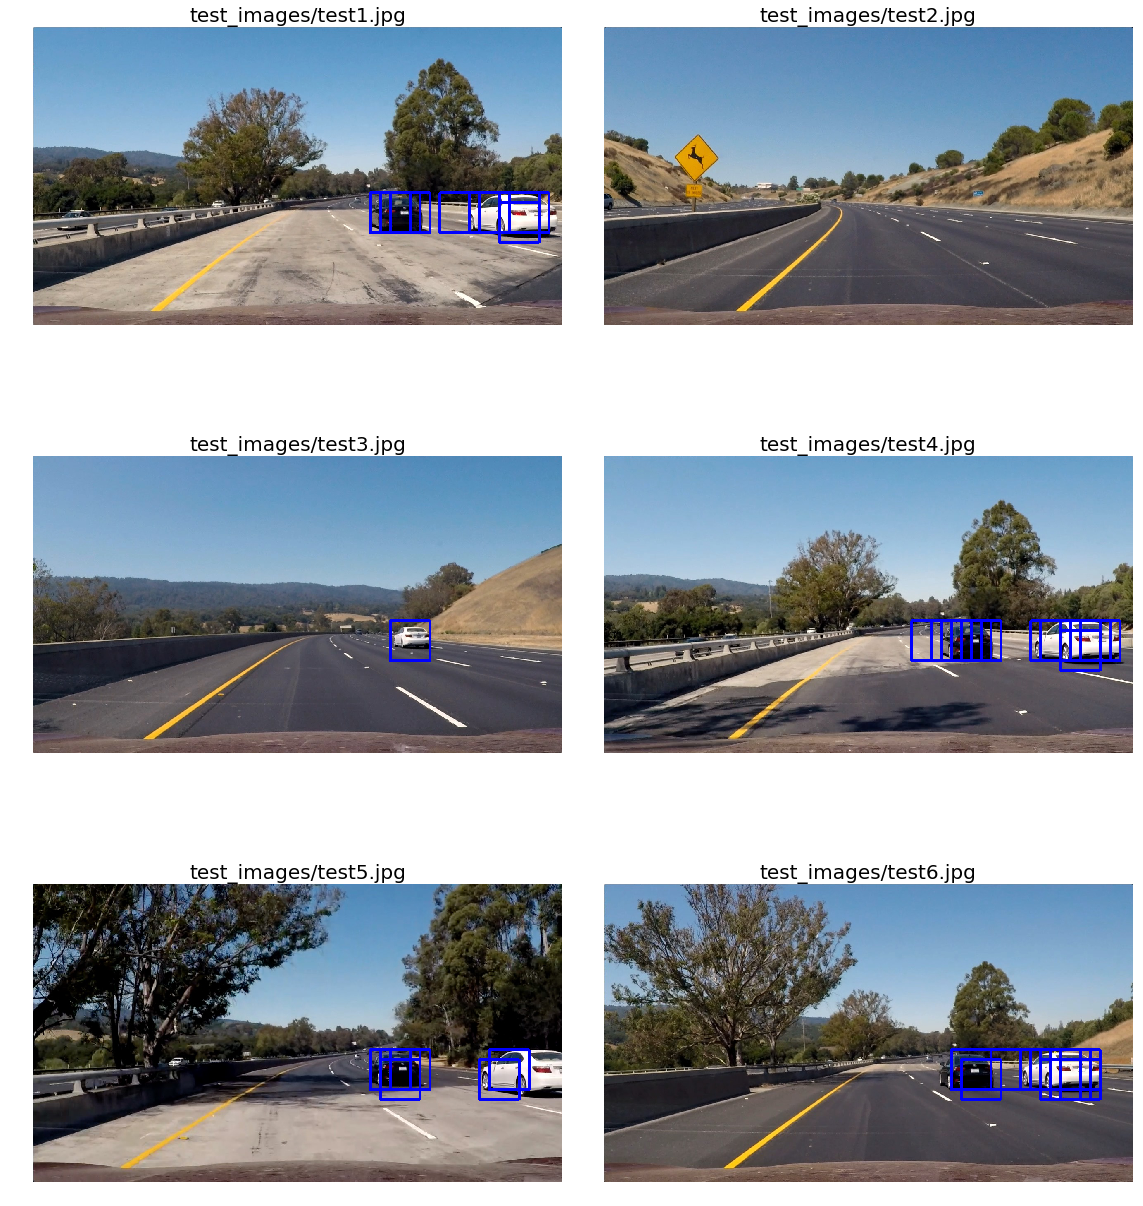

In [30]:
#5

dist_pickle = pickle.load(open("dist_pickle.p", "rb"))
svc = dist_pickle["svc"]


def draw_bbox(img, bbox_list):
    draw_img = np.copy(img)

    for bbox in bbox_list:
        cv2.rectangle(draw_img,bbox[0],bbox[1],(0,0,255),6)

    return draw_img


# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, conv='RGB2YCrCb', orient=9, pix_per_cell=8, cell_per_block=2):

    img = img.astype(np.float32)/255

    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv=conv)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))

    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1
    nfeat_per_block = orient*cell_per_block**2

    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    # 64 here is width and height of the images used to train SVM
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step

    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)

    bbox_list = []
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            # hog_feat1.shape before ravel() is (7,7,2,2,9) if nblocks_per_window = 7, cell_per_block = 2, orient = 9
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))

            # Scale features and make a prediction
            test_features = hog_features.reshape(1, -1)
            test_prediction = svc.predict(test_features)

            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                bbox = ((xbox_left, ytop_draw+ystart), (xbox_left+win_draw,ytop_draw+win_draw+ystart))
                bbox_list.append(bbox)

    return bbox_list
    

ystart = 400
ystop = 656
scale = 1.5

test_images = glob.glob('test_images/*.jpg')
imgs = [mpimg.imread(x) for x in test_images]
out_imgs = [draw_bbox(img, find_cars(img, ystart, ystop, scale, svc)) for img in imgs]

fig_sets = [(title, img) for title, img in zip(test_images, out_imgs)]

n_rows = 3
n_cols = 2
fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols*8, n_rows*6))
fig.tight_layout()
for i in range(n_rows):
    for j in range(n_cols):
        idx = i*n_cols+j
        title, img = fig_sets[idx]
        axs[i][j].axis('off')
        axs[i][j].imshow(img)
        axs[i][j].set_title(title, fontsize=20)

# plt.savefig('output_images/sliding_window.jpg')

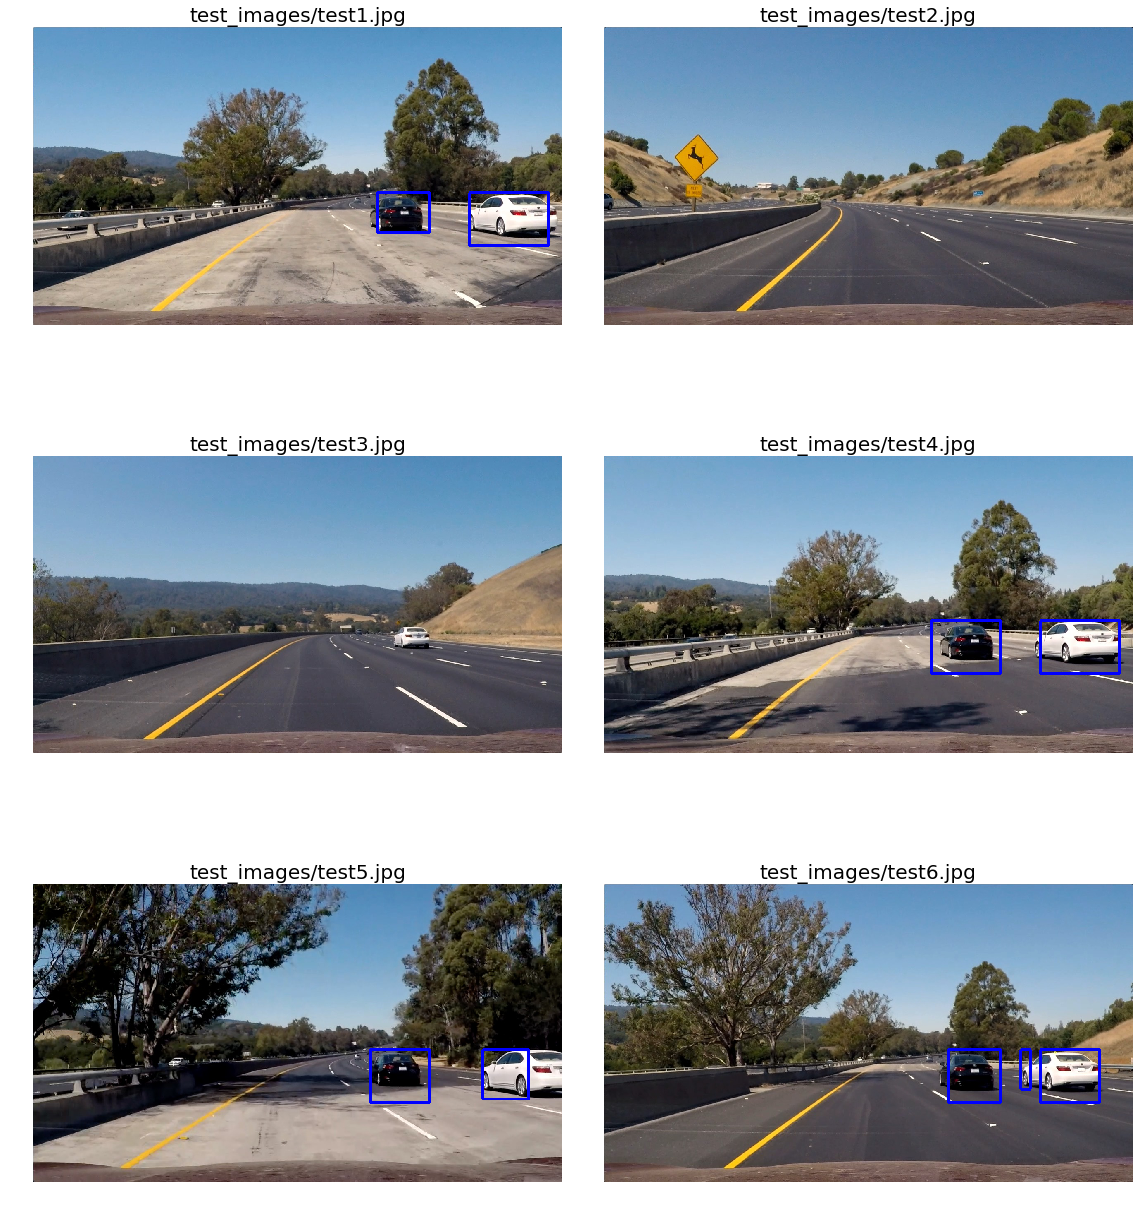

In [24]:
#6

from scipy.ndimage.measurements import label

dist_pickle = pickle.load(open("dist_pickle.p", "rb"))
svc = dist_pickle["svc"]


def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes


def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap


def labeled_bboxes(labels):
    bbox_list = []
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        bbox_list.append(bbox)
    return bbox_list


def pipeline(img, ystart=400, ystop=656, scales=[1.5, 2.0], heats=None, debug=False):
    bbox_list = []
    for scale in scales:
        bbox_list.extend(find_cars(img, ystart, ystop, scale, svc))

    heat = np.zeros_like(img[:,:,0]).astype(np.float)

    # Add heat to each box in box list
    heat = add_heat(heat,bbox_list)
    
    if heats is None:
        heats = []
    
    heats.append(heat)
    if len(heats) > 5:
        heats = heats[1:]
    
    heat = np.array(heats).mean(axis=0)
    
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,1/len(heats)+0.5)

    # Visualize the heatmap when displaying
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    out_img = draw_bbox(img, labeled_bboxes(labels))
    
    if debug:
        out_img_ex = draw_bbox(img, bbox_list)
        return out_img, heats, heatmap, out_img_ex
    else:
        return out_img, heats


test_images = glob.glob('test_images/*.jpg')
imgs = [mpimg.imread(x) for x in test_images]
out_imgs = [pipeline(img)[0] for img in imgs]


fig_sets = [(title, img) for title, img in zip(test_images, out_imgs)]

n_rows = 3
n_cols = 2
fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols*8, n_rows*6))
fig.tight_layout()
for i in range(n_rows):
    for j in range(n_cols):
        idx = i*n_cols+j
        title, img = fig_sets[idx]
        axs[i][j].axis('off')
        axs[i][j].imshow(img)
        axs[i][j].set_title(title, fontsize=20)

# plt.savefig('output_images/sliding_window.jpg')

In [31]:
class Processor:
    def __init__(self):
        self.heat = None
        self.heats = None
    
    def process_image(self, image):
        result, self.heats = pipeline(image, scales=[1.2, 1.5, 2.0], heats=self.heats)
        return result
    
    def process_image_ex(self, image):
        result, self.heats, self.heat, image_ex = pipeline(image, scales=[1.2, 1.5, 2.0], heats=self.heats, debug=True)
        heat = np.clip(self.heat * 64, 0, 255)
        image_heat = np.dstack((heat, heat, heat))
        return result, image_heat, image_ex

In [32]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

processor = Processor()

def process_image(image):
    return processor.process_image(image)

white_output = 'output_images/project_video.mp4'
clip1 = VideoFileClip("project_video.mp4")
# clip1 = VideoFileClip("project_video.mp4").subclip(1,6)
white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video output_images/project_video.mp4
[MoviePy] Writing video output_images/project_video.mp4



 12%|█▏        | 152/1261 [01:57<14:47,  1.25it/s]


 24%|██▍       | 303/1261 [03:56<12:27,  1.28it/s]


 36%|███▌      | 454/1261 [05:48<09:49,  1.37it/s]


 48%|████▊     | 605/1261 [07:40<08:02,  1.36it/s]


 60%|█████▉    | 756/1261 [09:34<06:26,  1.31it/s]


 72%|███████▏  | 907/1261 [11:28<04:09,  1.42it/s]


 84%|████████▍ | 1057/1261 [13:16<02:25,  1.40it/s]


 96%|█████████▌| 1205/1261 [15:02<00:44,  1.27it/s]


100%|█████████▉| 1260/1261 [15:43<00:00,  1.34it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/project_video.mp4 

CPU times: user 14min 24s, sys: 1min 42s, total: 16min 6s
Wall time: 15min 44s


In [26]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

processor = Processor()

# Process pipeline with aditional information
def process_image_ex(img):
    output, output1, output2 = processor.process_image_ex(img)
    output1 = cv2.resize(output1,(640, 360), interpolation = cv2.INTER_AREA)
    output2 = cv2.resize(output2,(640, 360), interpolation = cv2.INTER_AREA)

    # Create an array big enough to hold both images next to each other.
    vis = np.zeros((720, 1280+640, 3))

    # Copy both images into the composed image.
    vis[:720, :1280,:] = output
    vis[:360, 1280:1920,:] = output1
    vis[360:720, 1280:1920,:] = output2

    return vis

white_output = 'output_images/project_video_debug.mp4'
clip1 = VideoFileClip("project_video.mp4")
# clip1 = VideoFileClip("project_video.mp4").subclip(19,27)
white_clip = clip1.fl_image(process_image_ex)
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video output_images/project_video_debug.mp4
[MoviePy] Writing video output_images/project_video_debug.mp4



 12%|█▏        | 152/1261 [02:00<14:42,  1.26it/s]


 24%|██▍       | 303/1261 [04:00<12:27,  1.28it/s]


 36%|███▌      | 454/1261 [05:57<10:22,  1.30it/s]


 48%|████▊     | 605/1261 [07:53<08:18,  1.32it/s]


 60%|█████▉    | 756/1261 [09:54<06:42,  1.26it/s]


 72%|███████▏  | 907/1261 [12:03<04:53,  1.21it/s]


 84%|████████▍ | 1057/1261 [14:06<02:56,  1.16it/s]


 96%|█████████▌| 1205/1261 [16:08<00:43,  1.28it/s]


100%|█████████▉| 1260/1261 [16:54<00:00,  1.18it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/project_video_debug.mp4 

CPU times: user 15min 17s, sys: 2min 9s, total: 17min 27s
Wall time: 16min 55s
